In [1]:
%matplotlib inline
%gui qt

import os

import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.exposure import rescale_intensity

import utoolbox.util.files as fileutils
from utoolbox.container import Raster
from utoolbox.io.layouts import Volume
from utoolbox.analysis.roi import extract_mask, mask_to_contour

plt.rcParams['figure.figsize'] = (8, 8)

### Load data

In [2]:
source_folder = os.path.join("data", "20171201_RFiSHp2aLFCYC", "decon", "488")
print(source_folder)
file_list = fileutils.list_files(
    source_folder, 
    name_filters=[fileutils.ExtensionFilter('tif')]
)

#DEBUG bypass
file_path = file_list[1]
print(file_path)

data/20171201_RFiSHp2aLFCYC/decon/488
data/20171201_RFiSHp2aLFCYC/decon/488/cell4_ch0_stack0001_488nm_0010060msec_0007944791msecAbs_decon.tif


In [3]:
I = Raster(Volume, file_path)

In [4]:
from scipy.ndimage.interpolation import zoom
Id = zoom(I, [1., .102/.3, .102/.3])

In [5]:
Id.shape

(140, 275, 275)

Preview

shape=(140, 810, 810)
dtype=float32


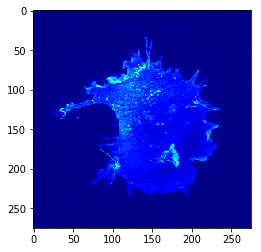

In [6]:
print("shape={}".format(I.shape))
print("dtype={}".format(I.dtype))

Ixy = np.amax(Id, axis=0)

plt.figure()
plt.imshow(Ixy, cmap='jet')

### Pre-process

Rescale to [0., 1.]

In [7]:
I = rescale_intensity(I, out_range=(0., 1.))
Id = rescale_intensity(Id, out_range=(0., 1.))

Obtain log spectrum

In [8]:
FI = np.fft.fftn(Id)

In [9]:
AI = np.abs(FI)
PI = np.angle(FI)

In [10]:
AIlog = np.log(AI)

In [11]:
from scipy.ndimage.filters import gaussian_filter
AIs = gaussian_filter(AIlog, sigma=3)

In [12]:
S = np.exp(AIs + 1j * PI)
S = np.real(np.fft.ifftn(S)**2)

In [13]:
S = gaussian_filter(S, sigma=3)

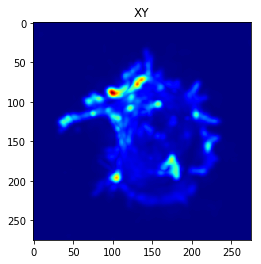

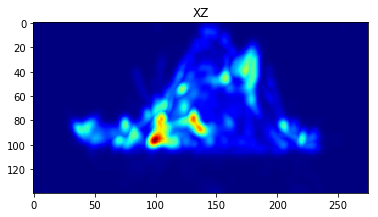

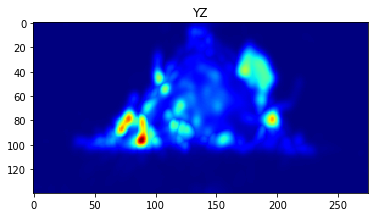

In [14]:
Itmp = np.copy(S)

plt.figure()
plt.title('XY')
plt.imshow(np.amax(Itmp, axis=0), cmap='jet')

plt.figure()
plt.title('XZ')
plt.imshow(np.amax(Itmp, axis=1), cmap='jet')

plt.figure()
plt.title('YZ')
plt.imshow(np.amax(Itmp, axis=2), cmap='jet')

### Create seeds

In [15]:
m = np.mean(S)
s = np.std(S)

T_fg = m + 2*s
T_bg = m #+ s

In [16]:
print("foreground={:.5f}, background={:.5f}".format(T_fg, T_bg))

foreground=0.00078, background=0.00008


In [17]:
F_1 = np.copy(Id)
F_1[S < T_fg] = 0

B_1 = np.copy(Id)
B_1[S > T_bg] = B_1.max()

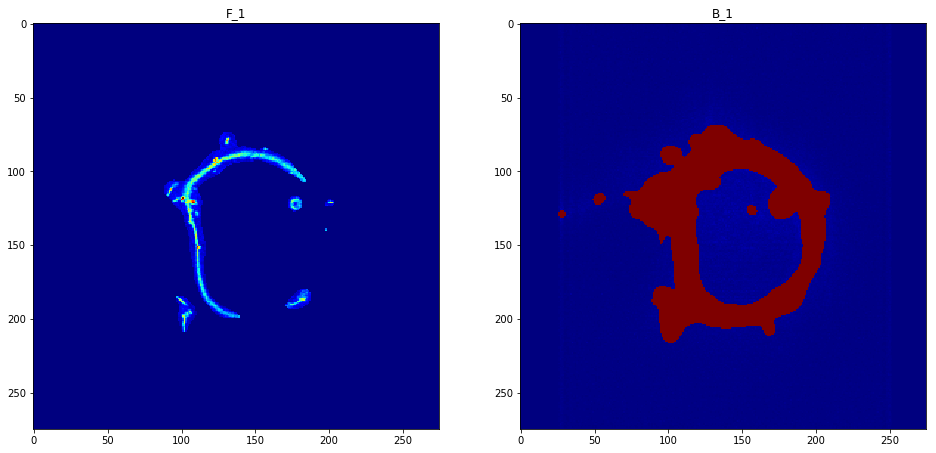

In [18]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('F_1')
plt.imshow(F_1[70, ...], cmap='jet')

plt.subplot(122)
plt.title('B_1')
plt.imshow(B_1[70, ...], cmap='jet')

In [19]:
T_fg2 = np.mean(F_1[F_1 > 0])

m = np.mean(B_1[B_1 > 0])
s = np.std(B_1[B_1 < B_1.max()])
T_bg2 = m + 2*s

In [20]:
print("foreground={:.5f}, background={:.5f}".format(T_fg2, T_bg2))

foreground=0.08921, background=0.12388


In [21]:
F_2 = F_1 > T_fg2
B_2 = B_1 < T_bg2

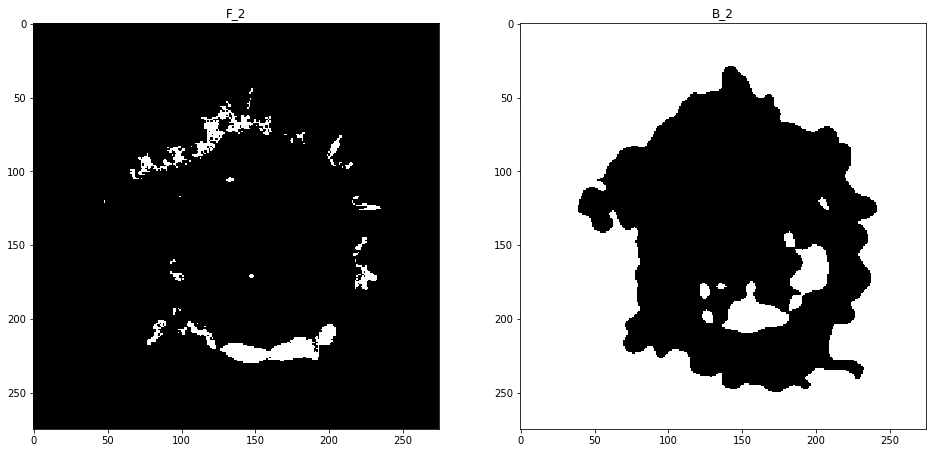

In [22]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('F_2')
plt.imshow(F_2[104, ...], cmap='gray')

plt.subplot(122)
plt.title('B_2')
plt.imshow(B_2[104, ...], cmap='gray')

In [23]:
imageio.volwrite("data/fg.tif", F_2.astype(np.uint8) * 255)
imageio.volwrite("data/bg.tif", B_2.astype(np.uint8) * 255)
imageio.volwrite("data/Id.tif", (I * 255).astype(np.uint8))

### Random walker segmentation

In [24]:
markers = np.zeros(Id.shape, dtype=np.uint)

'''
markers[~B_2] = 1. # undecided
markers[F_2] = 2. # foreground

markers /= np.max(markers)
'''

markers[F_2] = 1 # foreground
markers[B_2] = 2 # background

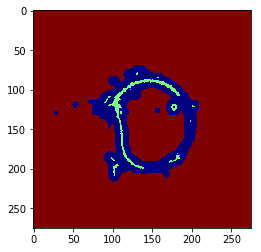

In [25]:
plt.figure()
plt.imshow(markers[70, ...], cmap='jet')

In [26]:
'''
z = 70
Is = I[z, ...]
ms = markers[z, ...]

L = chan_vese(Is, 
              mu=1e-5, 
              lambda1=.5, lambda2=1., 
              tol=1e-5, max_iter=1000, dt=0.5, 
              init_level_set=ms)

from skimage.morphology import binary_closing, disk
Lc = ~binary_closing(~L, disk(1))

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('L')
plt.imshow(L, cmap='gray')

plt.subplot(122)
plt.title('Lc')
plt.imshow(Lc, cmap='gray')
'''

"\nz = 70\nIs = I[z, ...]\nms = markers[z, ...]\n\nL = chan_vese(Is, \n              mu=1e-5, \n              lambda1=.5, lambda2=1., \n              tol=1e-5, max_iter=1000, dt=0.5, \n              init_level_set=ms)\n\nfrom skimage.morphology import binary_closing, disk\nLc = ~binary_closing(~L, disk(1))\n\nplt.figure(figsize=(16, 8))\n\nplt.subplot(121)\nplt.title('L')\nplt.imshow(L, cmap='gray')\n\nplt.subplot(122)\nplt.title('Lc')\nplt.imshow(Lc, cmap='gray')\n"

In [27]:
from skimage.segmentation import random_walker
#spacing = (.3, .102, .102)
spacing = (1., 1., 1.)
Pd = random_walker(Id, markers, spacing=spacing,
                   beta=100, 
                   mode='cg_mg', 
                   tol=1e-5, 
                   return_full_prob=True)

In [67]:
imageio.volwrite("data/Pd0.tif", Pd[0, ...].astype(np.float32))
imageio.volwrite("data/Pd1.tif", Pd[1, ...].astype(np.float32))

In [68]:
from skimage.transform import resize
P = np.zeros([Pd.shape[0]] + list(I.shape), dtype=Pd.dtype)
for z, Pz in enumerate(Pd):
    P[z, ...] = resize(Pz, I.shape, order=3, mode='constant')

In [69]:
P.shape

(2, 140, 810, 810)

In [70]:
print("max(P)={}, min(P)={}".format(P.max(), P.min()))

max(P)=1.0000164782937084, min(P)=0.0


In [71]:
imageio.volwrite("data/P0.tif", P[0, ...].astype(np.float32))
imageio.volwrite("data/P1.tif", P[1, ...].astype(np.float32))

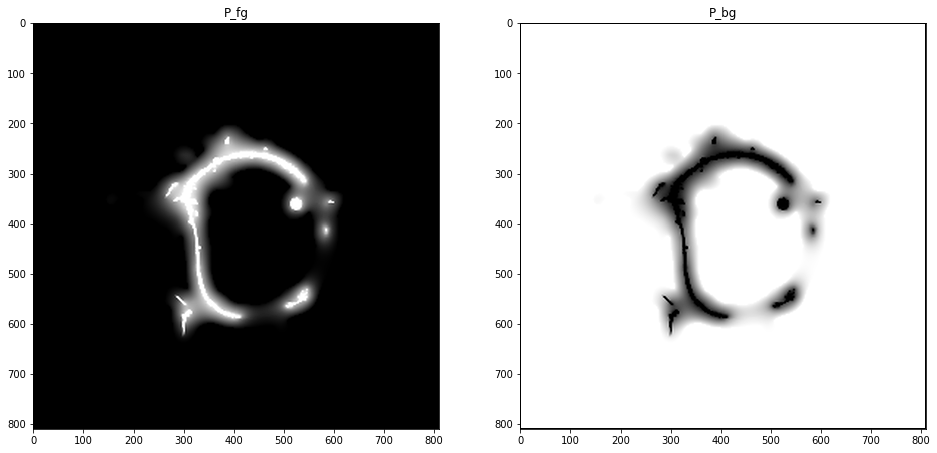

In [30]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('P_fg')
plt.imshow(P[0, 70, ...], cmap='gray')

plt.subplot(122)
plt.title('P_bg')
plt.imshow(P[1, 70, ...], cmap='gray')

### Upsampling

In [31]:
from scipy.ndimage.filters import convolve

In [72]:
# n-neighbor
k = np.array([
    [
        [0, 0, 0], 
        [0, 1, 0], 
        [0, 0, 0]
    ],
    [
        [0, 1, 0], 
        [1, 1, 1], 
        [0, 1, 0]
    ],
    [
        [0, 0, 0], 
        [0, 1, 0], 
        [0, 0, 0]
    ]
])
cc = np.count_nonzero(k)-1

# eta, balance the importance of weight
eta = 0.1
# tau, control the influence of I
tau = 0.9

q = np.zeros_like(P)

# iterate over classes
for ic, pc in enumerate(P):
    # pixel of interest
    m = pc > 0.99
    
    # cardinality
    c = np.count_nonzero(m)
    
    # mean intensity of seeds
    u = np.mean(I[m])
    
    # weight
    dI = I-u
    print("[{}] max(dI)={:.5f}".format(ic, dI.max()))
    w = ( 1 - ( dI/tau )**2 )**2
    w[np.abs(dI) > tau] = 0.
    
    # normalize
    q[ic, ...] = convolve(w * (pc+eta), k) / ((cc+1) * c)

[0] max(dI)=0.88642
[1] max(dI)=0.99480


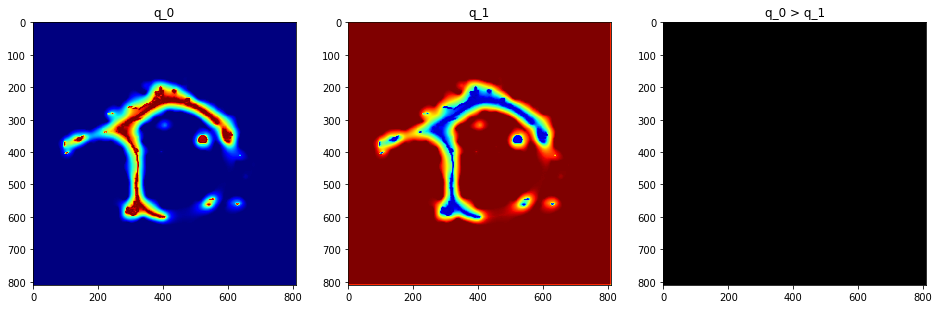

In [73]:
plt.figure(figsize=(16, 8))

z = 80

plt.subplot(131)
plt.title('q_0')
plt.imshow(q[0, z, ...], cmap='jet')

plt.subplot(132)
plt.title('q_1')
plt.imshow(q[1, z, ...], cmap='jet')

plt.subplot(133)
plt.title('q_0 > q_1')
plt.imshow(q[0, z, ...] > q[1, z, ...], cmap='gray')

In [75]:
imageio.volwrite("data/q0.tif", P[0, ...].astype(np.float32))
imageio.volwrite("data/q1.tif", P[1, ...].astype(np.float32))

In [ ]:
from ipywidgets import FloatProgress
from IPython.display import display
progress = FloatProgress(min=0, max=I.shape[0]-1)
display(progress)

In [ ]:
from utoolbox.segmentation import chan_vese
label = np.copy(I)
for z, (Is, ms) in enumerate(zip(I, markers)):
    label[z, ...] = chan_vese(Is, 
                              mu=1e-5, 
                              lambda1=.5, lambda2=1., 
                              tol=1e-5, max_iter=1000, dt=0.5, 
                              init_level_set=ms)
    progress.value = z

In [ ]:
imageio.volwrite("data/label.tif", label)